In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, auc
)


In [ ]:
breast_annotations = pd.read_csv(r'C:\Users\g0d2o\Downloads\project\final\breast-level_annotations.csv')
print(breast_annotations.head())


                           study_id                         series_id  \
0  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
1  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
2  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
3  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
4  8269f5971eaca3e5d3772d1796e6bd7a  d931832a0815df082c085b6e09d20aac   

                           image_id laterality view_position  height  width  \
0  d8125545210c08e1b1793a5af6458ee2          L            CC    3518   2800   
1  290c658f4e75a3f83ec78a847414297c          L           MLO    3518   2800   
2  cd0fc7bc53ac632a11643ac4cc91002a          R            CC    3518   2800   
3  71638b1e853799f227492bfb08a01491          R           MLO    3518   2800   
4  dd9ce3288c0773e006a294188aadba8e          L            CC    3518   2800   

  breast_birads breast_density     split  
0     BI-RADS 2      DENSITY C  training  


In [ ]:
def map_birads_to_label(birads):
    return 0 if birads == 'BI-RADS 1' else 1

breast_annotations['label'] = breast_annotations['breast_birads'].apply(map_birads_to_label)


C:\Users\g0d2o\AppData\Local\Temp\ipykernel_8376\2935758683.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=breast_annotations['label'], palette='coolwarm')


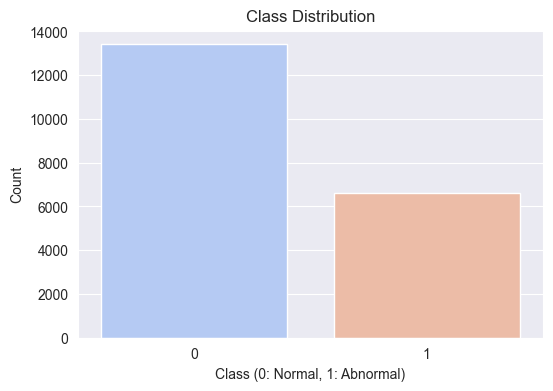

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=breast_annotations['label'], palette='coolwarm')
plt.xlabel("Class (0: Normal, 1: Abnormal)")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()


In [ ]:
train_data = breast_annotations[breast_annotations['split'] == 'training']
test_data = breast_annotations[breast_annotations['split'] == 'test']

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")


Training set size: 16000
Test set size: 4000


In [ ]:
def load_images(study_ids, image_ids, image_dir, target_size=(128, 128), sample_size=5):
    images = []
    sample_imgs = []
    sample_labels = []

    for i, (study_id, image_id) in enumerate(zip(study_ids, image_ids)):
        subfolder_path = os.path.join(image_dir, study_id)
        if not os.path.exists(subfolder_path):
            continue
        img_path = os.path.join(subfolder_path, f"{image_id}.jpg")
        if not os.path.exists(img_path):
            continue
        try:
            img = Image.open(img_path).convert('L')
            img = img.resize(target_size)
            img_array = np.array(img) / 255.0
            images.append(img_array)

            if i < sample_size:
                sample_imgs.append(img)
                sample_labels.append(image_id)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    return np.array(images), sample_imgs, sample_labels


In [ ]:
import numpy as np
import os

if os.path.exists("X_train.npy") and os.path.exists("X_test.npy"):
    print("Loading saved datasets...")

    X_train = np.load("X_train.npy")
    y_train = np.load("y_train.npy")
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")

    print("Datasets loaded successfully!")

else:
    print("Loading images and processing... This may take a while.")

    X_train, train_samples, train_labels = load_images(
        train_data['study_id'], train_data['image_id'], r'C:\Users\g0d2o\Downloads\project\final\images3'
    )
    y_train = train_data['label'].values

    X_test, test_samples, test_labels = load_images(
        test_data['study_id'], test_data['image_id'], r'C:\Users\g0d2o\Downloads\project\final\images3'
    )
    y_test = test_data['label'].values

    np.save("X_train.npy", X_train)
    np.save("y_train.npy", y_train)
    np.save("X_test.npy", X_test)
    np.save("y_test.npy", y_test)

    print("Datasets saved successfully!")


Loading saved datasets...
Datasets loaded successfully!


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=300)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print("After PCA: ", X_train.shape, X_test.shape)

After PCA:  (16000, 300) (4000, 300)


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (16000, 300)
y_train shape: (16000,)


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Final Train Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")


Final Train Set: (17158, 300), Validation Set: (4290, 300), Test Set: (4000, 300)


In [ ]:
from sklearn.metrics import classification_report, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
def tune_model(model, param_dist, X_train, y_train):
    grid_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                     n_iter=10, scoring='recall', cv=3,
                                     n_jobs=-1, random_state=42)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_


In [ ]:
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    "Decision Tree": {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    "Random Forest": {
        'n_estimators': [300, 500],
        'max_depth': [15, 20, 25],
        'min_samples_split': [2, 5],
        'class_weight': ["balanced_subsample"]
    },
    "k-NN": {
        'n_neighbors': [3, 5, 7, 10, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    "SVM": {
        'C': [0.01, 0.1, 1],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
}


In [ ]:
print(" Tuning hyperparameters for Logistic Regression...")
logreg = tune_model(LogisticRegression(class_weight="balanced", max_iter=1000),
                    param_grids["Logistic Regression"], X_train, y_train)

logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print("\n  - Classification Report:")
print(classification_report(y_test, y_pred_logreg))

logreg_recall = recall_score(y_test, y_pred_logreg)
print(f" Logistic Regression Recall: {logreg_recall:.2f}")


 Tuning hyperparameters for Logistic Regression...

 Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.52      0.58      2682
           1       0.32      0.47      0.38      1318

    accuracy                           0.50      4000
   macro avg       0.49      0.49      0.48      4000
weighted avg       0.55      0.50      0.52      4000

 Logistic Regression Recall: 0.47


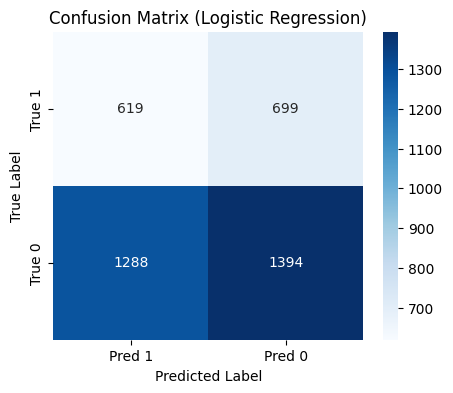

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, model_name="Logistic Regression"):

    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 1", "Pred 0"], yticklabels=["True 1", "True 0"])
    plt.title(f"Confusion Matrix ({model_name})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(y_test, y_pred_logreg, "Logistic Regression")


In [ ]:
print(" Tuning hyperparameters for Decision Tree...")
dt = tune_model(DecisionTreeClassifier(class_weight="balanced"),
                param_grids["Decision Tree"], X_train, y_train)

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("\n Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred_dt))

dt_recall = recall_score(y_test, y_pred_dt)
print(f" Decision Tree Recall: {dt_recall:.2f}")


 Tuning hyperparameters for Decision Tree...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



 Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.51      0.58      2682
           1       0.33      0.49      0.39      1318

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.49      4000
weighted avg       0.56      0.50      0.52      4000

 Decision Tree Recall: 0.49


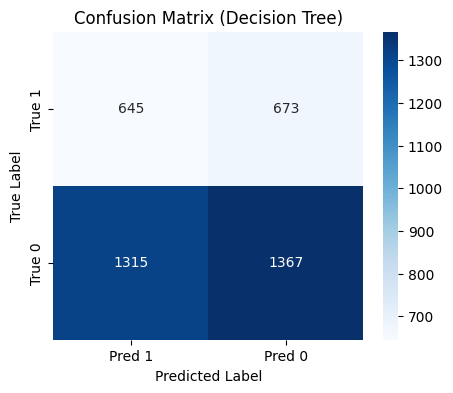

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, model_name="Decision Tree"):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 1", "Pred 0"], yticklabels=["True 1", "True 0"])
    plt.title(f"Confusion Matrix ({model_name})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree")


In [ ]:
X_train_svm = X_train_scaled[:1000]
y_train_svm = y_train[:1000]
X_test_svm = X_test_scaled[:200]
y_test_svm = y_test[:200]

print(f"SVM Training set size: {X_train_svm.shape[0]}")
print(f"SVM Test set size: {X_test_svm.shape[0]}")

In [12]:
print("Tuning hyperparameters for SVM...")

svm = SVC(kernel="rbf", probability=True, class_weight="balanced")
svm.fit(X_train_svm, y_train_svm)
y_pred_svm = svm.predict(X_test_svm)
print("SVM:")
print(classification_report(y_test_svm, y_pred_svm))

# Вывод Recall отдельно
svm_recall = recall_score(y_test, y_pred_svm)
print(f"SVM Recall: {svm_recall:.2f}")



 SVM - Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.53      0.64      150
           1       0.30      0.60      0.40       50

    accuracy                           0.55       200
   macro avg       0.55      0.57      0.52       200
weighted avg       0.68      0.55      0.58       200


 SVM Recall: 0.60


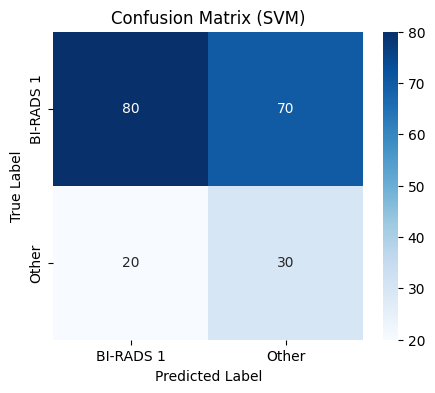

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, model_name="SVM"):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["BI-RADS 1", "Other"], yticklabels=["BI-RADS 1", "Other"])
    plt.title(f"Confusion Matrix ({model_name})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(y_test_svm, y_pred_svm, "SVM")


In [ ]:
rf = RandomForestClassifier(class_weight="balanced", n_estimators=200, max_depth=15, min_samples_split=5)
knn = KNeighborsClassifier(n_neighbors=7, weights="distance")


In [ ]:
print(" Tuning hyperparameters for k-NN...")
knn = tune_model(KNeighborsClassifier(), param_grids["k-NN"], X_train, y_train)

knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("\n k-NN - Classification Report:")
print(classification_report(y_test, y_pred_knn))

knn_recall = recall_score(y_test, y_pred_knn)
print(f" k-NN Recall: {knn_recall:.2f}")


 Tuning hyperparameters for k-NN...

 k-NN - Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.42      0.52      2682
           1       0.34      0.60      0.43      1318

    accuracy                           0.48      4000
   macro avg       0.51      0.51      0.48      4000
weighted avg       0.57      0.48      0.49      4000

 k-NN Recall: 0.60


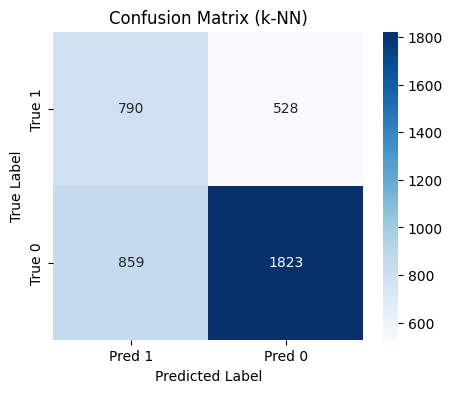

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, model_name="k-NN"):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 1", "Pred 0"], yticklabels=["True 1", "True 0"])
    plt.title(f"Confusion Matrix ({model_name})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(y_test, y_pred_knn, "k-NN")


In [11]:
print(" Tuning hyperparameters for Random Forest...")
rf = tune_model(RandomForestClassifier(class_weight="balanced_subsample"),
                param_grids["Random Forest"], X_train, y_train)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

rf_recall = recall_score(y_test, y_pred_rf)
print(f" Random Forest Recall: {rf_recall:.2f}")



 Random Forest - Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.72      0.70      2682
           1       0.37      0.48      0.35      1318

    accuracy                           0.59      4000
   macro avg       0.53      0.60      0.53      4000
weighted avg       0.58      0.59      0.59      4000


 Random Forest Recall: 0.48


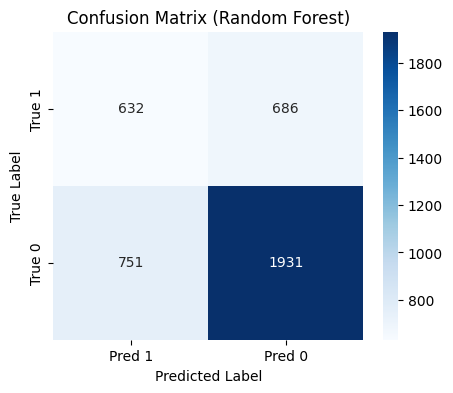

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, model_name="Random Forest"):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 1", "Pred 0"], yticklabels=["True 1", "True 0"])
    plt.title(f"Confusion Matrix ({model_name})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")


In [19]:
recall_scores = {
    "Logistic Regression": logreg_recall,
    "Decision Tree": dt_recall,
    "Random Forest": rf_recall,
    "k-NN": knn_recall,
    "SVM": svm_recall
}

best_model_name = max(recall_scores, key=recall_scores.get)
print(f"\n Best Model: {best_model_name} (Recall = {recall_scores[best_model_name]:.2f})")



 Recall Scores:
 Logistic Regression: 0.47
 Decision Tree: 0.49
 Random Forest: 0.48
 k-NN: 0.60
 SVM: 0.60

 Best Model: k-NN (Recall = 0.60)
